<a href="https://colab.research.google.com/github/grandff/kdn-machinelearning/blob/main/KDN_PJT_%EC%9E%90%EC%A0%84%EA%B1%B0_%EC%88%98%EC%9A%94_%EC%98%88%EC%B8%A1_(%EC%8B%A4%EC%8A%B5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 모듈 import 

필요한 모듈을 import 합니다. 필요에 따라 추가 패키지를 load 할 수 있습니다.

In [1]:
!wget http://49.247.133.7/KDN_DAY3.zip
!mkdir data
!unzip KDN_DAY3.zip -d data

--2021-10-07 04:33:41--  http://49.247.133.7/KDN_DAY3.zip
Connecting to 49.247.133.7:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115586 (1.1M) [application/zip]
Saving to: ‘KDN_DAY3.zip’

KDN_DAY3.zip        100%[===================>]   1.06M  3.22MB/s    in 0.3s    

2021-10-07 04:33:42 (3.22 MB/s) - ‘KDN_DAY3.zip’ saved [1115586/1115586]

Archive:  KDN_DAY3.zip
 extracting: data/submission.csv     
 extracting: data/test.csv           
 extracting: data/train.csv          


In [2]:
!pip install jaen

In [3]:
# 실전프로젝트 환경 설정
from JAEN.project import Project
pjt = Project('자전거 대여량 예측', # 프로젝트 이름
              '한전KDN',                       # 과정명
              '1차수 A반',                     # 차수 정보
              '198080@kdn.com')                  # 이메일 (숫자@kdn.com) * 본인의 이메일로 수정

In [4]:
import json
import datetime
import requests
from sklearn.metrics import mean_squared_error

def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

## 데이터 로드

2개의 데이터 셋트를 나누어 제공합니다.

1. train: 학습용 데이터 세트. 정답 값이라고 할 수 있는 `label` 값이 같이 제공됩니다.
2. test: 예측용 데이터 세트. 정답 값이 빠진 `feature` 들만 제공됩니다. 우리는 이 `feature`를 활용하여 예측을 진행합니다.
3. submission: 정답 제출용 데이터 세트. 주어진 형식에 맞춰 정답 값을 기입하고 제출합니다.

In [7]:
# train 데이터셋 로드 (train.csv)
train = pd.read_csv('./data/train.csv')
# test 데이터셋 로드 (test.csv)
test = pd.read_csv('./data/test.csv')

## 데이터 개요 확인

로드한 DataFrame의 가장 기본적인 데이터 구조 및 결측치를 확인합니다.

In [8]:
# train 앞 부분 5개 행 출력
train.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [9]:
# test 앞 부분 5개 행 출력
test.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [10]:
# train, test 의 shape 확인
train.shape, test.shape

((10886, 12), (6493, 9))

In [13]:
# train column 별 데이터 개수, 타입 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [14]:
# test column 별 데이터 개수, 타입 확인
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [15]:
# train 결측치 확인 
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [16]:
# test 결측치 확인
test.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [17]:
# datetime 컬럼 변환
# datetime64 타입으로 변환
# train 데이터셋 
train['datetime'] = pd.to_datetime(train['datetime'])

In [18]:
# 연도(year), 월(month), 일(day), 요일(dayofweek), 분기(quarter), 시(hour), 분(minute), 초(second) 컬럼 생성
# 생성된 컬럼에 datetime 컬럼으로부터 정보를 추출하여 대입
# train 데이터셋 
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['dayofweek'] = train['datetime'].dt.dayofweek
train['quarter'] = train['datetime'].dt.quarter
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second

In [19]:
# datetime 컬럼 변환
# datetime64 타입으로 변환
# test 데이터셋 
test['datetime'] = pd.to_datetime(test['datetime'])

In [20]:
# 연도(year), 월(month), 일(day), 요일(dayofweek), 분기(quarter), 시(hour), 분(minute), 초(second) 컬럼 생성
# 생성된 컬럼에 datetime 컬럼으로부터 정보를 추출하여 대입
# test
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['dayofweek'] = test['datetime'].dt.dayofweek
test['quarter'] = test['datetime'].dt.quarter
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second

## Feature(컬럼) 선택

분석을 토대로 머신러닝 알고리즘에 입력할 feature(컬럼)를 선택합니다.

In [23]:
# 본인의 판단에 따라 훈련에 사용할 feature와 사용하지 않을 feature를 선택합니다.
## casual register count만 제외
features = [
    'season',
     'holiday',
     'workingday',
     'weather',
     'temp',
     'atemp',
     'humidity',
     'windspeed',
     'year',
     'month',
     'day',
     'dayofweek',
     'quarter',
     'hour',
     'minute',
     'second'
]

# Features(X값)

In [25]:
# features의 컬럼을 X로 설정한다.
X = train[features]
X

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,quarter,hour,minute,second
0,1,0,0,1,9.84,14.395,81,0.0000,2011,1,1,5,1,0,0,0
1,1,0,0,1,9.02,13.635,80,0.0000,2011,1,1,5,1,1,0,0
2,1,0,0,1,9.02,13.635,80,0.0000,2011,1,1,5,1,2,0,0
3,1,0,0,1,9.84,14.395,75,0.0000,2011,1,1,5,1,3,0,0
4,1,0,0,1,9.84,14.395,75,0.0000,2011,1,1,5,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,2012,12,19,2,4,19,0,0
10882,4,0,1,1,14.76,17.425,57,15.0013,2012,12,19,2,4,20,0,0
10883,4,0,1,1,13.94,15.910,61,15.0013,2012,12,19,2,4,21,0,0
10884,4,0,1,1,13.94,17.425,61,6.0032,2012,12,19,2,4,22,0,0


## Label(Y값)

In [27]:
# count 값을 Y값으로 설정한다.
Y = train['count']
Y

0         16
1         40
2         32
3         13
4          1
        ... 
10881    336
10882    241
10883    168
10884    129
10885     88
Name: count, Length: 10886, dtype: int64

## 훈련(Train) / 검증(Validation) 세트 분할

- random_state=123
- test_size=0.2

In [28]:
from sklearn.model_selection import train_test_split
## random_state ???
## test_size = 0.2 -> 80% , 20%로 훈련, 테스트 데이터 나눔
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=123, test_size=0.2)

## 모델 정의
- RandomForestRegressor 사용
    - n_estimators=500,random_state=123,n_jobs=1 적용

In [29]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=500, random_state=123, n_jobs=1).fit(x_train, y_train)
model.score(x_train, y_train), model.score(x_test, y_test)

(0.9933656573097778, 0.9468400208974246)

In [30]:
# x_test에 대한 예측
# 결과 값은 pred 변수에 저장
pred = model.predict(x_test)
pred

array([183.49 ,   3.054, 103.156, ..., 299.946, 327.378,   4.652])

## 평가지표 & 검증 (Evaluation)

In [31]:
# y_test와 pred 사이의 RMSLE 결과 확인 
# 평가지표 결과 출력
RMSLE(y_test, pred)

0.3345960077569905

## 예측 (Predict)

In [32]:
# test 데이터셋에 대한 예측
prediction = model.predict(test[features])

# 1단계 제출

In [34]:
submission = pd.read_csv('./data/submission.csv')
submission['count'] = prediction
submission

,datetime,count
0,2011-01-20 00:00:00,14.024
1,2011-01-20 01:00:00,6.260
2,2011-01-20 02:00:00,6.656
3,2011-01-20 03:00:00,2.730
4,2011-01-20 04:00:00,2.352
...,...,...
6488,2012-12-31 19:00:00,317.008
6489,2012-12-31 20:00:00,209.494
6490,2012-12-31 21:00:00,165.216
6491,2012-12-31 22:00:00,117.136


In [35]:
pjt.submit(submission)

파일을 저장하였습니다. 파일명: submission-04-46-57.csv
제출 여부 :success
오늘 제출 횟수 : 1
제출 결과:0.48685


# 2단계 Y Label 값 스케일 변환

<function matplotlib.pyplot.show>

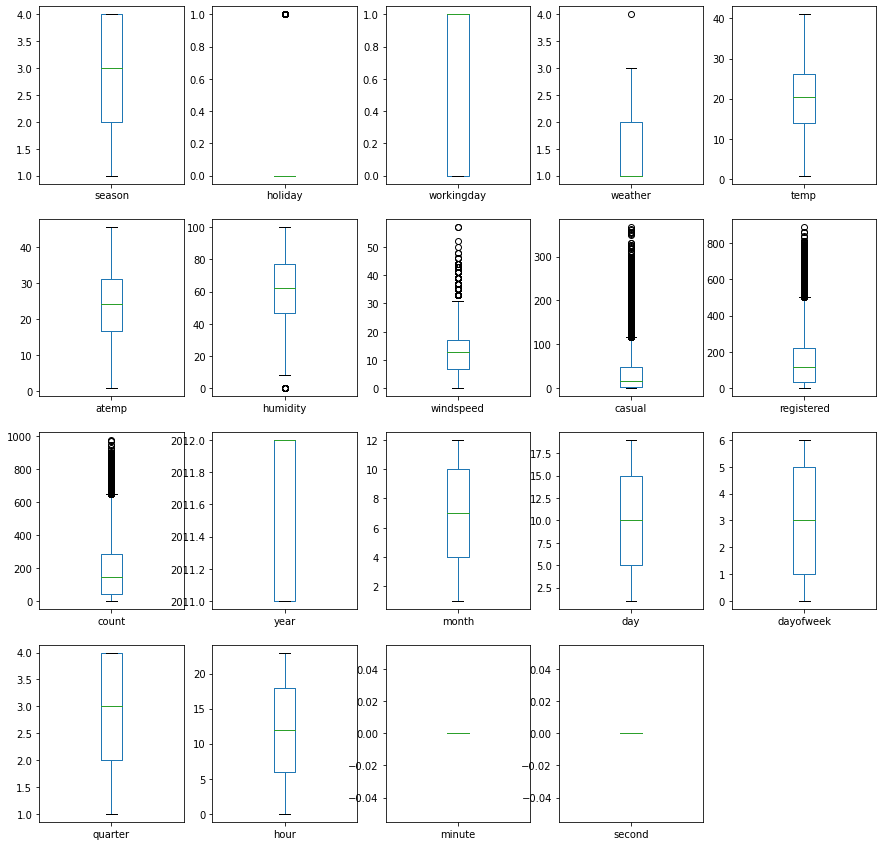

In [39]:
train.plot(kind='box', figsize=(15,15), subplots=True, layout=(4,5))
plt.show
# casual, registerd, count의 분포를 균등하게 하는, 즉 스케일 변환 작업을 하고 나서 다시 학습

In [40]:
# casual, registered, count에 대하여 log1p 변환을 하고
# casual_log, registered_log, count_log 컬럼을 생성한 후 대입합니다.
# train 데이터셋 적용
train['casual_log'] = np.log1p(train['casual'])
train['registered_log'] = np.log1p(train['registered'])
train['count_log'] = np.log1p(train['count'])
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,quarter,hour,minute,second,casual_log,registered_log,count_log
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,5,1,0,0,0,1.386294,2.639057,2.833213
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,5,1,1,0,0,2.197225,3.496508,3.713572
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,5,1,2,0,0,1.791759,3.332205,3.496508
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,5,1,3,0,0,1.386294,2.397895,2.639057
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,5,1,4,0,0,0.000000,0.693147,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,2,4,19,0,0,2.079442,5.799093,5.820083
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,2,4,20,0,0,2.397895,5.446737,5.488938
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,2,4,21,0,0,1.609438,5.105945,5.129899
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,2,4,22,0,0,2.564949,4.770685,4.867534


In [41]:
# 데이터 분할, random_state=123, test_size=0.2 설정
# y에는 'count_log' 지정
x_train, x_test, y_train, y_test = train_test_split(X, train['count_log'], random_state=123, test_size=0.2)

- RandomForestRegressor 사용
    - n_estimators=500,random_state=123,n_jobs=1 적용

In [42]:
model_log = RandomForestRegressor(n_estimators=500, random_state=123, n_jobs=1).fit(x_train, y_train)
model_log.score(x_train, y_train), model_log.score(x_test, y_test)

(0.9938754388349956, 0.9537572155259949)

In [43]:
# test 데이터셋에 대한 예측
prediction = model_log.predict(test[features])

In [44]:
# expm1 함수를 이용하여 예측된 결과를 변환
## log1p 변환을 했으므로 expm1으로 다시 돌리는거 같은데?
prediction = np.expm1(prediction)

In [45]:
submission['count'] = prediction
pjt.submit(submission)

파일을 저장하였습니다. 파일명: submission-04-53-26.csv
제출 여부 :success
오늘 제출 횟수 : 2
제출 결과:0.44888


# 3단계 Registered / Casual 나누어 예측 모델 생성

`count`는 `registered` + `casual` 입니다.

**총 대여량 = 등록된 회원 + 일반 회원 이 빌린 숫자의 합**입니다.

registered를 예측하는 모델 / causal을 예측하는 모델 2개를 만들어 각각 예측 후 합산된 결과를 도출합니다.

**요구사항**
- registered_log를 y값으로 예측하는 모델 생성
- casual_log를 y값으로 예측하는 모델 생성
- train_test_split(random_state=123, test_size=0.2)
- RandomForestRegressor 알고리즘 사용 (random_state=123, n_estimators=500)

In [46]:
# x에는 정의한 train[features], 
X = train[features]
X

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,quarter,hour,minute,second
0,1,0,0,1,9.84,14.395,81,0.0000,2011,1,1,5,1,0,0,0
1,1,0,0,1,9.02,13.635,80,0.0000,2011,1,1,5,1,1,0,0
2,1,0,0,1,9.02,13.635,80,0.0000,2011,1,1,5,1,2,0,0
3,1,0,0,1,9.84,14.395,75,0.0000,2011,1,1,5,1,3,0,0
4,1,0,0,1,9.84,14.395,75,0.0000,2011,1,1,5,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,2012,12,19,2,4,19,0,0
10882,4,0,1,1,14.76,17.425,57,15.0013,2012,12,19,2,4,20,0,0
10883,4,0,1,1,13.94,15.910,61,15.0013,2012,12,19,2,4,21,0,0
10884,4,0,1,1,13.94,17.425,61,6.0032,2012,12,19,2,4,22,0,0


In [48]:
#y에는 casual_log','registered_log', 'count' 지정
Y = train[['casual_log','registered_log','count']]
Y

,casual_log,registered_log,count
0,1.386294,2.639057,16
1,2.197225,3.496508,40
2,1.791759,3.332205,32
3,1.386294,2.397895,13
4,0.000000,0.693147,1
...,...,...,...
10881,2.079442,5.799093,336
10882,2.397895,5.446737,241
10883,1.609438,5.105945,168
10884,2.564949,4.770685,129


## 모델 정의

In [49]:
# rfc_reg => RandomForestRegressor 를 생성, n_estimators=500, random_state=123
# y값: Y['registered_log'] 변수로 설정
rfc_reg = RandomForestRegressor(n_estimators=500, random_state=123, n_jobs=1).fit(X, Y['registered_log'])
rfc_reg.score(X, Y['registered_log'])

0.9941875004526082

In [50]:
# rfc_cas => RandomForestRegressor 를 생성, n_estimators=750, random_state=123
# y값: Y['casual_log'] 변수로 설정
rfc_cas = RandomForestRegressor(n_estimators=750, random_state=123, n_jobs=1).fit(X, Y['casual_log'])
rfc_cas.score(X, Y['casual_log'])

0.9862611822707016

## 예측 결과 확인

## registered / casual 각각 예측

In [51]:
# test[features]예측
# rfc_reg 모델로 예측
rfc_reg_val = rfc_reg.predict(test[features])
# 예측값 exp1 변환
rfc_reg_pred = np.expm1(rfc_reg_val)

In [52]:
# rfc_cas 모델로 예측
rfc_cas_val = rfc_cas.predict(test[features])
# 예측값 exp1 변환
rfc_cas_pred = np.expm1(rfc_cas_val)

In [53]:
# rfc_pred 변수에 결과를 합산합니다.
rfc_pred = rfc_reg_pred + rfc_cas_pred

In [54]:
submission['count'] = rfc_pred
pjt.submit(submission)

파일을 저장하였습니다. 파일명: submission-05-00-21.csv
제출 여부 :success
오늘 제출 횟수 : 3
제출 결과:0.44151


## 4단계 다른 알고리즘 사용

In [55]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [60]:
# KNeighborsRegressor
model_reg = KNeighborsRegressor(n_neighbors=30).fit(X, Y['registered_log'])
model_reg_val = model_reg.predict(test[features])
model_reg_pred = np.expm1(model_reg_val)

model_cas = KNeighborsRegressor(n_neighbors=30).fit(X, Y['casual_log'])
model_cas_val = model_cas.predict(test[features])
model_cas_pred = np.expm1(model_cas_val)

kne_pred = model_reg_pred + model_cas_pred

In [61]:
submission['count'] = kne_pred
pjt.submit(submission)

파일을 저장하였습니다. 파일명: submission-05-12-01.csv
제출 여부 :success
오늘 제출 횟수 : 6
제출 결과:0.9636


In [62]:
# LinearRegression
model_reg = LinearRegression().fit(X, Y['registered_log'])
model_reg_val = model_reg.predict(test[features])
model_reg_pred = np.expm1(model_reg_val)

model_cas = LinearRegression().fit(X, Y['casual_log'])
model_cas_val = model_cas.predict(test[features])
model_cas_pred = np.expm1(model_cas_val)

lin_pred = model_reg_pred + model_cas_pred

submission['count'] = lin_pred
pjt.submit(submission)

파일을 저장하였습니다. 파일명: submission-05-12-42.csv
제출 여부 :success
오늘 제출 횟수 : 7
제출 결과:1.04663


In [63]:
# DecisionTreeRegressor
model_reg = DecisionTreeRegressor().fit(X, Y['registered_log'])
model_reg_val = model_reg.predict(test[features])
model_reg_pred = np.expm1(model_reg_val)

model_cas = DecisionTreeRegressor().fit(X, Y['casual_log'])
model_cas_val = model_cas.predict(test[features])
model_cas_pred = np.expm1(model_cas_val)

dec_pred = model_reg_pred + model_cas_pred

submission['count'] = dec_pred
pjt.submit(submission)

파일을 저장하였습니다. 파일명: submission-05-13-05.csv
제출 여부 :success
오늘 제출 횟수 : 8
제출 결과:0.54336


In [73]:
# GradientBoostingRegressor
model_reg = GradientBoostingRegressor(n_estimators=500, random_state=123).fit(X, Y['registered_log'])
model_reg_val = model_reg.predict(test[features])
model_reg_pred = np.expm1(model_reg_val)

model_cas = GradientBoostingRegressor(n_estimators=750, random_state=123).fit(X, Y['casual_log'])
model_cas_val = model_cas.predict(test[features])
model_cas_pred = np.expm1(model_cas_val)

gra_pred = model_reg_pred + model_cas_pred

submission['count'] = gra_pred
pjt.submit(submission)

파일을 저장하였습니다. 파일명: submission-05-21-02.csv
제출 여부 :success
오늘 제출 횟수 : 12
제출 결과:0.41314


In [76]:
# LGBMRegressor
model_reg = LGBMRegressor().fit(X, Y['registered_log'])
model_reg_val = model_reg.predict(test[features])
model_reg_pred = np.expm1(model_reg_val)

model_cas = LGBMRegressor().fit(X, Y['casual_log'])
model_cas_val = model_cas.predict(test[features])
model_cas_pred = np.expm1(model_cas_val)

lgbm_pred = model_reg_pred + model_cas_pred

submission['count'] = lgbm_pred
pjt.submit(submission)

파일을 저장하였습니다. 파일명: submission-05-23-59.csv
제출 여부 :success
오늘 제출 횟수 : 15
제출 결과:0.39733


In [77]:
# XGBRegressor
model_reg = XGBRegressor().fit(X, Y['registered_log'])
model_reg_val = model_reg.predict(test[features])
model_reg_pred = np.expm1(model_reg_val)

model_cas = XGBRegressor().fit(X, Y['casual_log'])
model_cas_val = model_cas.predict(test[features])
model_cas_pred = np.expm1(model_cas_val)

xgb_pred = model_reg_pred + model_cas_pred

submission['count'] = xgb_pred
pjt.submit(submission)

[05:24:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:24:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
파일을 저장하였습니다. 파일명: submission-05-24-33.csv
제출 여부 :success
오늘 제출 횟수 : 16
제출 결과:0.45692


In [ ]:
# XGBRegressor
# y_train['casual_log']로 지정


In [ ]:
# XGBRegressor registered_log 모델로 예측


# XGBRegressor casual_log 모델로 예측


# xgb_pred 변수에 결과를 합산합니다.



In [ ]:
submission['count'] = xgb_pred
pjt.submit(submission)

In [ ]:
# 